### 250424 MLOps

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import tensorflow
import tensorflow as tf
from tensorflow import keras
import imageio
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import glob
import time
import PIL
from IPython import display
from sklearn.model_selection import train_test_split

2025-04-24 07:41:11.085901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 07:41:12.020742: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
%matplotlib inline

#### 매직 명령어에 주석을 붙이면 실행이 안 됨
- %matplotlib inline # 시각화 결과를 ipynb 내에서 표시 <- 이런 식으로 하면 안 됨

In [4]:
print(tf.__version__)
print(imageio.__version__)

2.10.0
2.35.1


### 데이터셋: CIFAR 10
- 라벨링이 잘못된 특정 인덱스에 접근해서 수정해야 함
```
0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck
```

In [5]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 이미지 확인 및 라벨 수정 함수

In [6]:
def view_and_correct_label(x_data, y_data, index, new_label=None):
    """
    이미지를 보여주고 레이블을 수정할 수 있는 함수
    
    Parameters:
    -----------
    x_data : numpy.ndarray
        이미지 데이터 배열
    y_data : numpy.ndarray
        레이블 데이터 배열
    index : int
        확인/수정할 이미지의 인덱스
    new_label : int, optional
        새로 지정할 레이블, None인 경우 수정하지 않음
    
    Returns:
    --------
    original_label : int
        원래 레이블 값
    """
    
    # 원본 이미지와 레이블 표시
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x_data[index])
    original_label = y_data[index][0]
    plt.title(f"Original image (Label: {original_label})")
    
    # 레이블 수정 (지정된 경우)
    if new_label is not None:
        y_data[index][0] = new_label
        
        # 수정된 레이블로 이미지 다시 표시
        plt.subplot(1, 2, 2)
        plt.imshow(x_data[index])
        plt.title(f"Corrected image (Original: {original_label}, New: {new_label})")
    
    plt.tight_layout()
    plt.show()
    
    return original_label

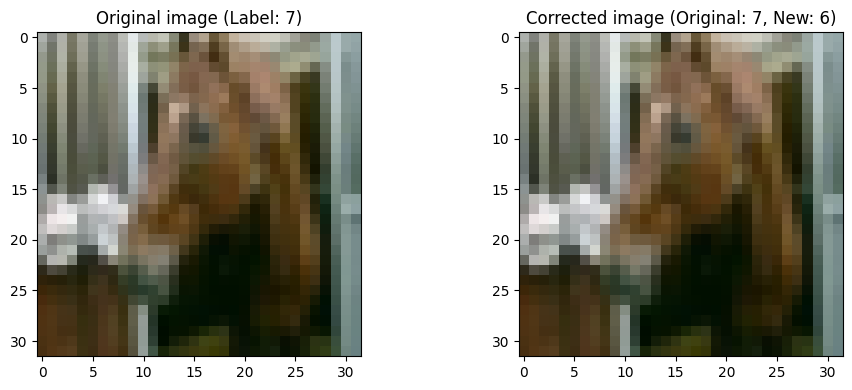

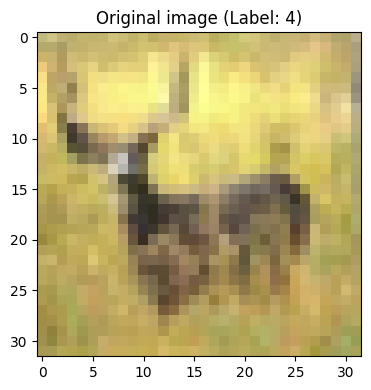

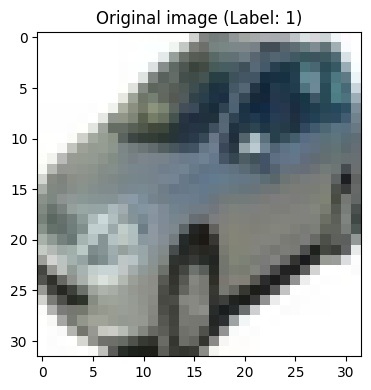

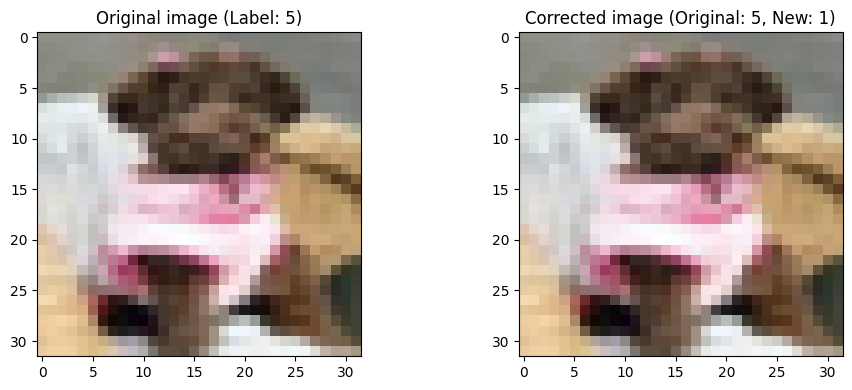

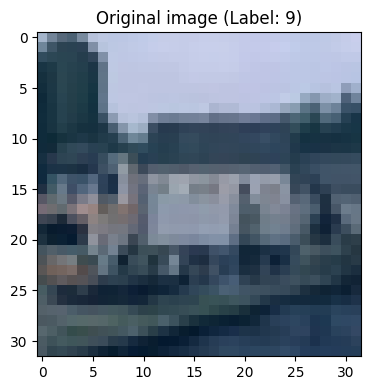

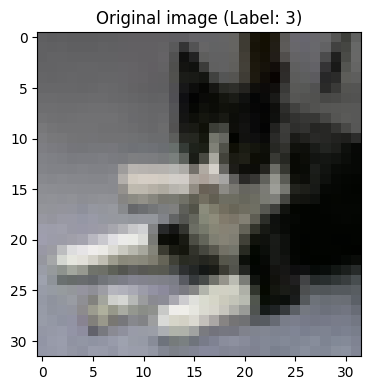

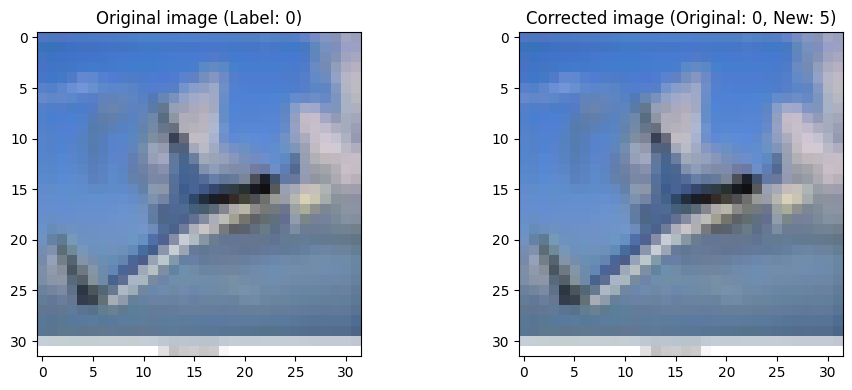

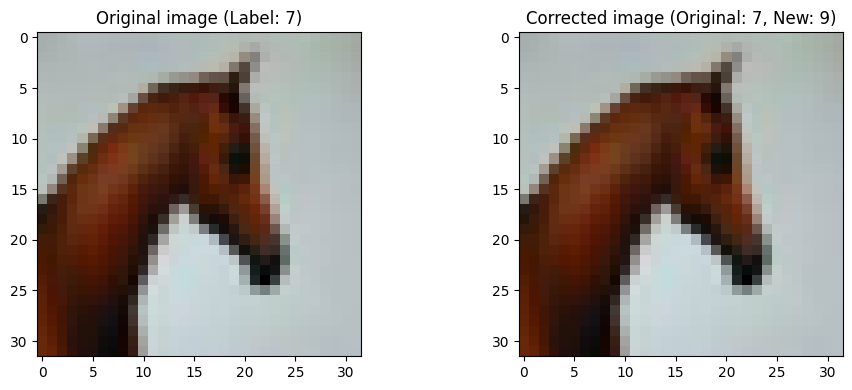

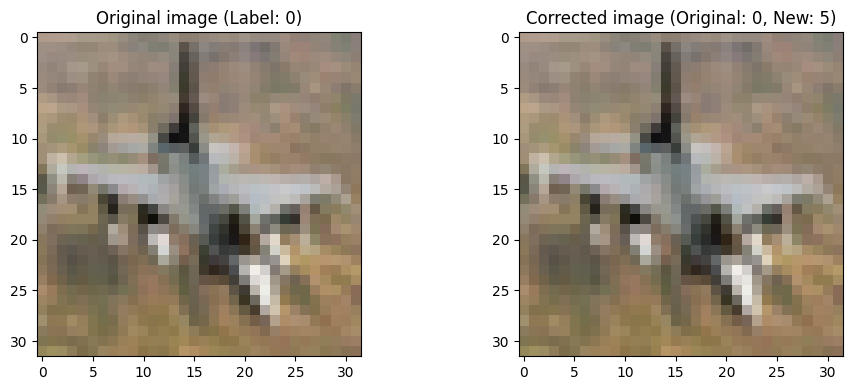

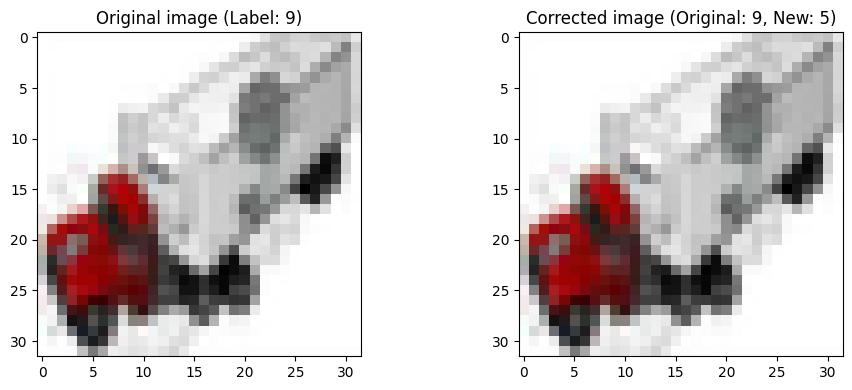

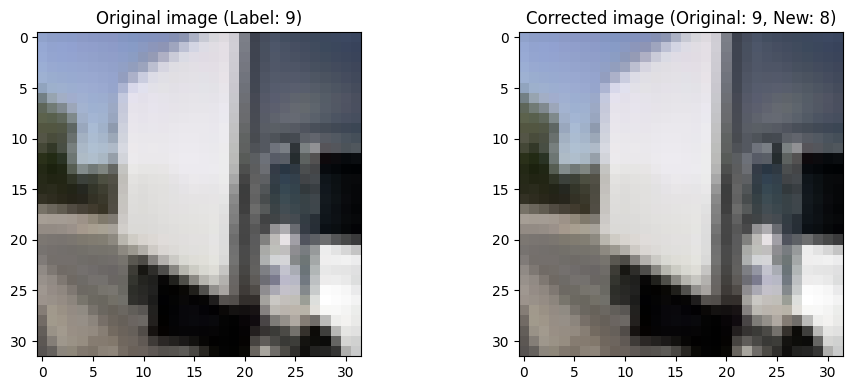

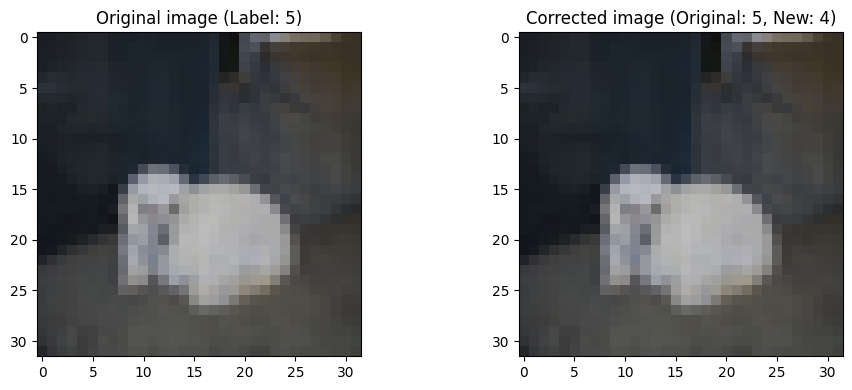

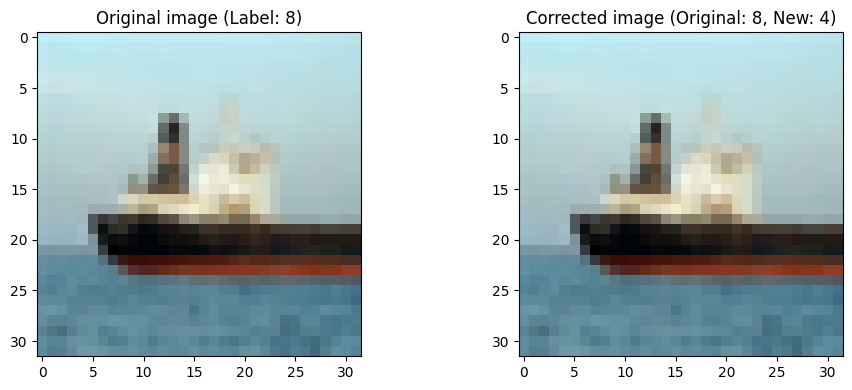

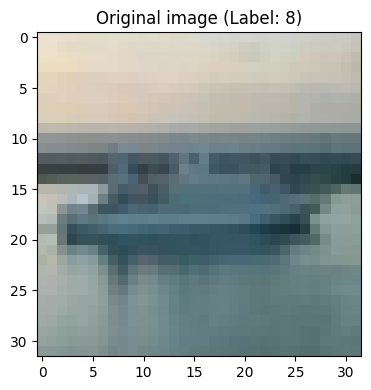

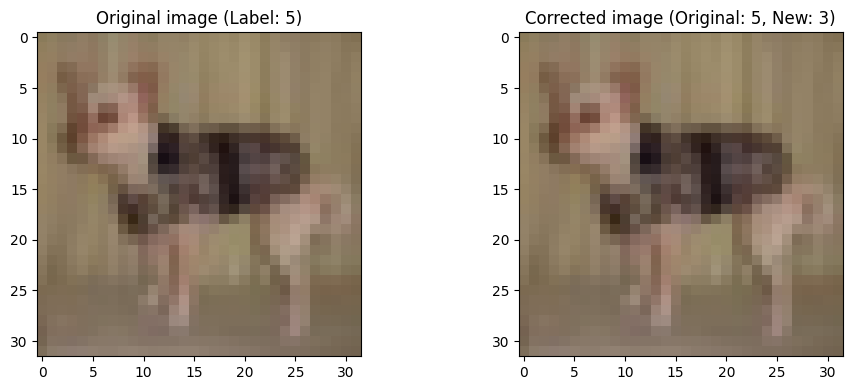

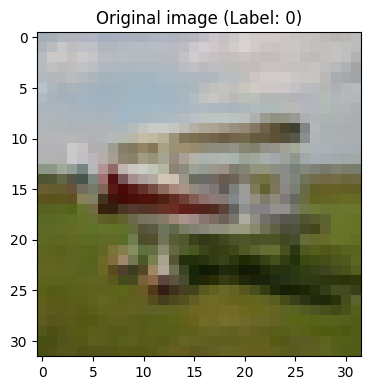

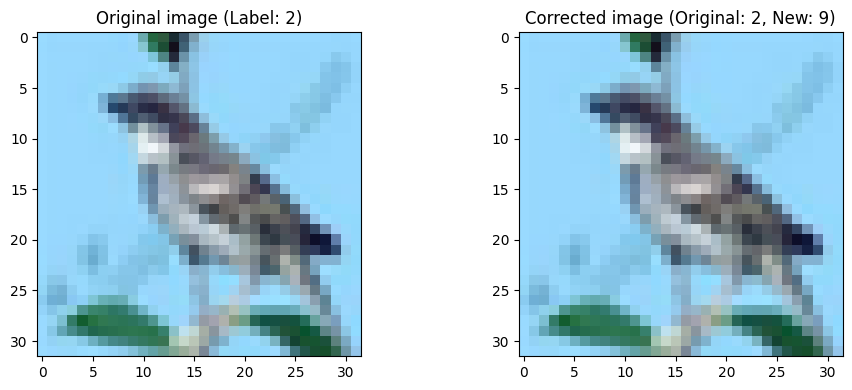

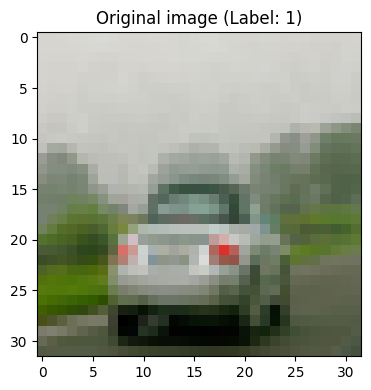

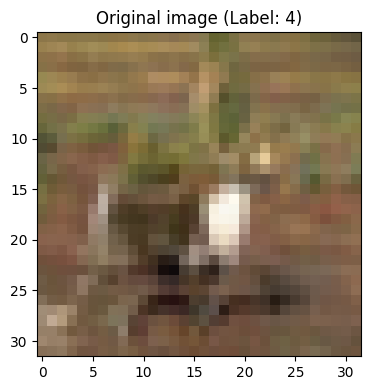

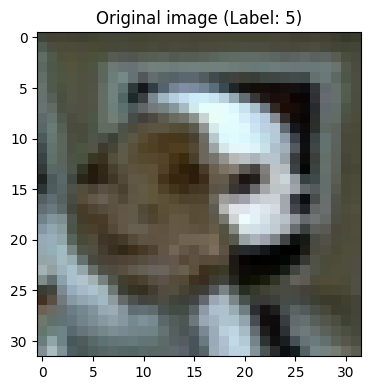

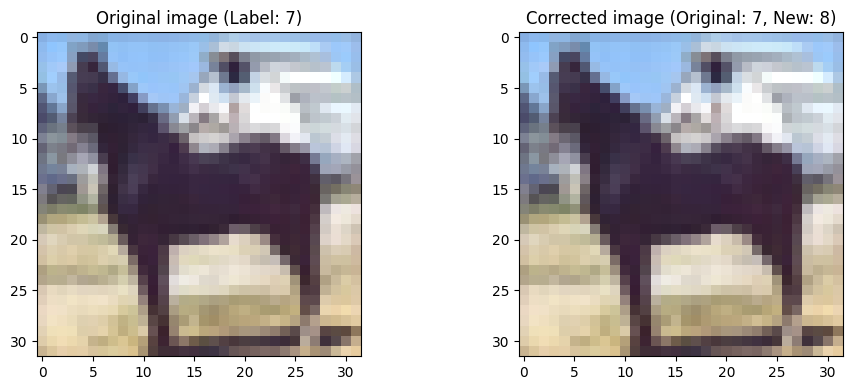

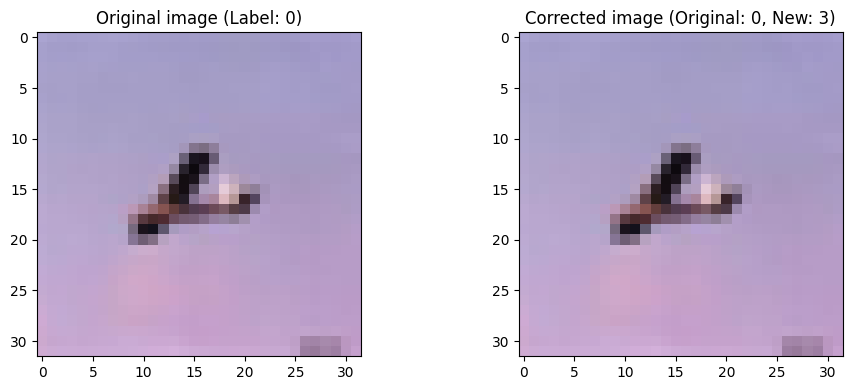

0

In [7]:
# 이미지 확인 및 수정
view_and_correct_label(x_train, y_train, 2405, new_label=6)
view_and_correct_label(x_train, y_train, 6877) # 그냥 비행기 맞는 것 같음
view_and_correct_label(x_train, y_train, 8058) # 그냥 사슴 맞는 것 같음
view_and_correct_label(x_train, y_train, 2532, new_label=1)
view_and_correct_label(x_train, y_train, 7657) # 누가 봐도 타조임
view_and_correct_label(x_train, y_train, 1969) # 차 맞음
view_and_correct_label(x_train, y_train, 2804, new_label=5)
view_and_correct_label(x_train, y_train, 6792, new_label=9) # 뭔지 모르겠는데 고양이보단 트럭에 가까운듯
view_and_correct_label(x_train, y_train, 1227, new_label=5)
view_and_correct_label(x_train, y_train, 5191, new_label=5)
view_and_correct_label(x_train, y_train, 1718, new_label=8)
view_and_correct_label(x_train, y_train, 5690, new_label=4)
view_and_correct_label(x_train, y_train, 2592, new_label=4)
view_and_correct_label(x_train, y_train, 4794) # 너무 사슴임
view_and_correct_label(x_train, y_train, 5960, new_label=3)
view_and_correct_label(x_train, y_train, 165) # 새는 확실히 아님
view_and_correct_label(x_train, y_train, 9227, new_label=9)
view_and_correct_label(x_train, y_train, 5632) # 고양이 맞음
view_and_correct_label(x_train, y_train, 9352) # 캠핑카는 트럭일까 차량일까? 차량이 맞는 것 같음
view_and_correct_label(x_train, y_train, 7846) # 그냥 개구리가 맞음
view_and_correct_label(x_train, y_train, 6966, new_label=8)
view_and_correct_label(x_train, y_train, 5468, new_label=3)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# 전처리
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [9]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # CIFAR-10의 클래스 10개
])

2025-04-24 07:41:23.995644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 07:41:24.027645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 07:41:24.027889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 07:41:24.029017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 64)         0         
 ePooling2D)                                                     
                                                        

In [12]:
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val)
)

2025-04-24 07:41:26.615322: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.
2025-04-24 07:41:26.795202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/20


2025-04-24 07:41:30.018932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-04-24 07:41:32.188157: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-24 07:41:32.188197: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-04-24 07:41:32.188265: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-04-24 07:41:33.905073: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 12s 6ms/step - loss: 1.6948 - accuracy: 0.4464 - val_loss: 1.4984 - val_accuracy: 0.4706
Epoch 2/20
625/625 [==============================] - 3s 6ms/step - loss: 1.1567 - accuracy: 0.5937 - val_loss: 1.1461 - val_accuracy: 0.5980
Epoch 3/20
625/625 [==============================] - 3s 6ms/step - loss: 0.9935 - accuracy: 0.6507 - val_loss: 1.0429 - val_accuracy: 0.6451
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 0.8867 - accuracy: 0.6894 - val_loss: 1.1091 - val_accuracy: 0.6220
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.8013 - accuracy: 0.7177 - val_loss: 1.0547 - val_accuracy: 0.6473
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 0.7138 - accuracy: 0.7485 - val_loss: 0.9647 - val_accuracy: 0.6849
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.6496 - accuracy: 0.7721 - val_loss: 1.0861 - val_accuracy: 0.6460
Epoch 8/20
625/6

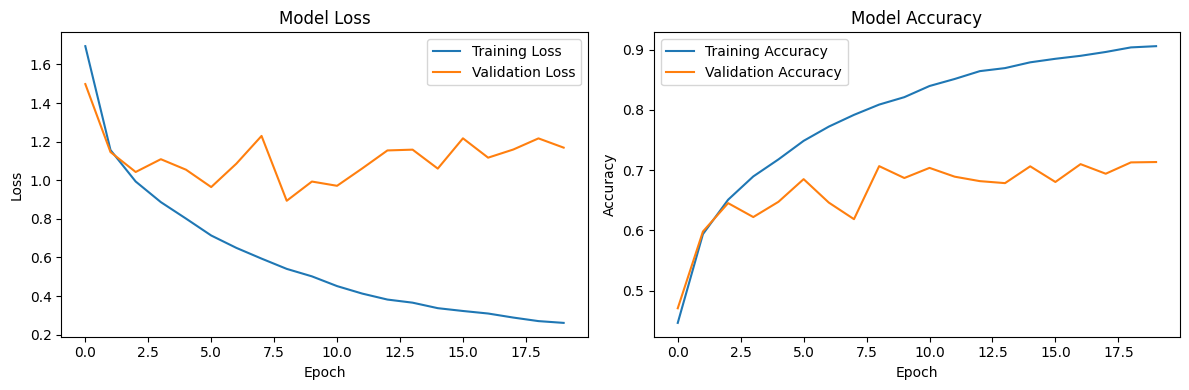

In [13]:
# 손실(Loss) 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()